# **Homework 2 - Classification**
若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

Binary classification is one of the most fundamental problem in machine learning. In this tutorial, you are going to build linear binary classifiers to predict whether the income of an indivisual exceeds 50,000 or not. We presented a discriminative and a generative approaches, the logistic regression(LR) and the linear discriminant anaysis(LDA). You are encouraged to compare the differences between the two, or explore more methodologies. Although you can finish this tutorial by simpliy copying and pasting the codes, we strongly recommend you to understand the mathematical formulation first to get more insight into the two algorithms. Please find [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) and [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf) for more detailed information about the two algorithms.

二元分類是機器學習中最基礎的問題之一，在這份教學中，你將學會如何實作一個線性二元分類器，來根據人們的個人資料，判斷其年收入是否高於 50,000 美元。我們將以兩種方法: logistic regression 與 generative model，來達成以上目的，你可以嘗試了解、分析兩者的設計理念及差別。針對這兩個演算法的理論基礎，可以參考李宏毅老師的教學投影片 [logistic regression](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) 與 [generative model](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)。

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# Dataset

This dataset is obtained by removing unnecessary attributes and balancing the ratio between positively and negatively labeled data in the [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)), which can be found in [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php). Only preprocessed and one-hot encoded data (i.e. *X_train*,  *Y_train* and *X_test*) will be used in this tutorial. Raw data (i.e. *train.csv* and *test.csv*) are provided to you in case you are interested in it.

這個資料集是由 [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php) 的 [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)) 經過一些處理而得來。為了方便訓練，我們移除了一些不必要的資訊，並且稍微平衡了正負兩種標記的比例。事實上在訓練過程中，只有 X_train、Y_train 和 X_test 這三個經過處理的檔案會被使用到，train.csv 和 test.csv 這兩個原始資料檔則可以提供你一些額外的資訊。

# Logistic Regression

In this section we will introduce logistic regression first. We only present how to implement it here, while mathematical formulation and analysis will be omitted. You can find more theoretical detail in [Prof. Lee's lecture](https://www.youtube.com/watch?v=hSXFuypLukA).

首先我們會實作 logistic regression，針對理論細節說明請參考[李宏毅老師的教學影片](https://www.youtube.com/watch?v=hSXFuypLukA)

### Preparing Data

Load and normalize data, and then split training data into training set and development set.

下載資料，並且對每個屬性做正規化，處理過後再將其切分為訓練集與發展集。

In [1]:
import numpy as np

np.random.seed(0)
X_train_fpath = '../data/X_train'
Y_train_fpath = '../data/Y_train'
X_test_fpath = '../data/X_test'
output_fpath = '../results/output_{}.csv'

# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510


## T-test

In [2]:
X_train_0 = X_train[Y_train == 0]
X_train_1 = X_train[Y_train == 1]
X_train_0.shape, X_train_1.shape

((38784, 510), (10046, 510))

In [3]:
from scipy import stats

In [4]:
bool_value = stats.ttest_ind(X_train_0, X_train_1)[1] < 0.05

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [5]:
bool_value.shape

(510,)

In [6]:
X_train = (X_train.T[bool_value]).T
X_dev = (X_dev.T[bool_value]).T
X_test = (X_test.T[bool_value]).T
data_dim = X_train.shape[1]

In [7]:
X_train.shape, X_dev.shape, X_test.shape

((48830, 380), (5426, 380), (27622, 380))


### Some Useful Functions

Some functions that will be repeatedly used when iteratively updating the parameters.

這幾個函數可能會在訓練迴圈中被重複使用到。

In [8]:
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmoid(np.matmul(X, w) + b)

def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X, w, b)).astype(np.int)
    
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

### Functions about gradient and loss

Please refers to [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)(p.12) for the formula of gradient and loss computation.

請參考[李宏毅老師上課投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)第 12 頁的梯度及損失函數計算公式。

In [9]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad


## Progress bar

In [10]:
def _progress_bar(
    epoch,
    max_iter,
    percentage,
    training_acc,
    training_loss,
    dev_acc,
    dev_loss,
    block = 10
):
    if percentage == 100.:
        print('\r',
              '[Epoch %d/%d]:[%s]%.1f%%' % (epoch, max_iter, '█' * block, 100.0),
              'training_acc: %.4f' % training_acc,
              'training_loss: %.4f' % training_loss,
              'dev_acc: %.4f' % dev_acc,
              'dev_loss: %.4f' % dev_loss,
              ';\n\n',
              end = '')
    else:
        print('\r',
              '[Epoch %d/%d]:[%s%s]%.1f%%' % (epoch, max_iter,
                                           '█' * int(percentage*block/100),
                                           ' ' * (block-int(percentage*block/100)),
                                           float(percentage)),
              end = '')

### Training

Everything is prepared, let's start training! 

Mini-batch gradient descent is used here, in which training data are split into several mini-batches and each batch is fed into the model sequentially for losses and gradients computation. Weights and bias are updated on a mini-batch basis.

Once we have gone through the whole training set,  the data have to be re-shuffled and mini-batch gradient desent has to be run on it again. We repeat such process until max number of iterations is reached.

我們使用小批次梯度下降法來訓練。訓練資料被分為許多小批次，針對每一個小批次，我們分別計算其梯度以及損失，並根據該批次來更新模型的參數。當一次迴圈完成，也就是整個訓練集的所有小批次都被使用過一次以後，我們將所有訓練資料打散並且重新分成新的小批次，進行下一個迴圈，直到事先設定的迴圈數量達成為止。

In [15]:
# Zero initialization for weights ans bias
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# Some parameters for training    
max_iter = 6000
batch_size = 200
learning_rate = 0.0005
early_stopping_iter = 100
temp_acc = 0
temp_epoch = 0

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Calcuate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
    
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
            
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
        
        y_train_pred = _f(X_train, w, b)
        Y_train_pred = np.round(y_train_pred)
        T_acc = _accuracy(Y_train_pred, Y_train)
        T_loss = _cross_entropy_loss(y_train_pred, Y_train) / train_size
        
        y_dev_pred = _f(X_dev, w, b)
        Y_dev_pred = np.round(y_dev_pred)
        D_acc = _accuracy(Y_dev_pred, Y_dev)
        D_loss = _cross_entropy_loss(y_dev_pred, Y_dev) / dev_size
        
        # progress bar
        if idx == int(np.floor(train_size / batch_size)) - 1:
            _progress_bar(epoch+1, max_iter, 100., T_acc, T_loss, D_acc, D_loss)
        else:
            _progress_bar(epoch+1, max_iter, idx * batch_size * 100 / train_size, T_acc, T_loss, D_acc, D_loss)

    train_acc.append(T_acc)
    train_loss.append(T_loss)

    dev_acc.append(D_acc)
    dev_loss.append(D_loss)
        
    # early stopping
    if D_acc > temp_acc:
        temp_acc = np.copy(D_acc)
        temp_epoch = 0
        
        temp_w = np.copy(w)
        temp_b = np.copy(b)
        temp_step = np.copy(step)
    else:
        if temp_epoch < early_stopping_iter:
            temp_epoch += 1
        else:
            print("early stopping at epoch:", epoch - temp_epoch)
            
            train_acc[:-temp_epoch-1]
            train_loss[:-temp_epoch-1]

            dev_acc[:-temp_epoch-1]
            dev_loss[:-temp_epoch-1]
            
            w = temp_w
            b = temp_b
            step = temp_step
            break

 [Epoch 1/6000]:[██████████]100.0% training_acc: 0.8511 training_loss: 0.4012 dev_acc: 0.8437 dev_loss: 0.4069 ;

 [Epoch 2/6000]:[██████████]100.0% training_acc: 0.8625 training_loss: 0.3686 dev_acc: 0.8531 dev_loss: 0.3754 ;

 [Epoch 3/6000]:[██████████]100.0% training_acc: 0.8675 training_loss: 0.3515 dev_acc: 0.8586 dev_loss: 0.3590 ;

 [Epoch 4/6000]:[██████████]100.0% training_acc: 0.8702 training_loss: 0.3405 dev_acc: 0.8603 dev_loss: 0.3484 ;

 [Epoch 5/6000]:[██████████]100.0% training_acc: 0.8716 training_loss: 0.3326 dev_acc: 0.8614 dev_loss: 0.3409 ;

 [Epoch 6/6000]:[██████████]100.0% training_acc: 0.8730 training_loss: 0.3266 dev_acc: 0.8618 dev_loss: 0.3352 ;

 [Epoch 7/6000]:[██████████]100.0% training_acc: 0.8737 training_loss: 0.3218 dev_acc: 0.8618 dev_loss: 0.3306 ;

 [Epoch 8/6000]:[██████████]100.0% training_acc: 0.8748 training_loss: 0.3180 dev_acc: 0.8633 dev_loss: 0.3269 ;

 [Epoch 9/6000]:[██████████]100.0% training_acc: 0.8754 training_loss: 0.3147 dev_acc: 0

 [Epoch 72/6000]:[██████████]100.0% training_acc: 0.8812 training_loss: 0.2795 dev_acc: 0.8721 dev_loss: 0.2918 ;

 [Epoch 73/6000]:[██████████]100.0% training_acc: 0.8811 training_loss: 0.2794 dev_acc: 0.8721 dev_loss: 0.2917 ;

 [Epoch 74/6000]:[██████████]100.0% training_acc: 0.8811 training_loss: 0.2793 dev_acc: 0.8719 dev_loss: 0.2916 ;

 [Epoch 75/6000]:[██████████]100.0% training_acc: 0.8812 training_loss: 0.2791 dev_acc: 0.8721 dev_loss: 0.2915 ;

 [Epoch 76/6000]:[██████████]100.0% training_acc: 0.8812 training_loss: 0.2790 dev_acc: 0.8723 dev_loss: 0.2914 ;

 [Epoch 77/6000]:[██████████]100.0% training_acc: 0.8811 training_loss: 0.2789 dev_acc: 0.8721 dev_loss: 0.2913 ;

 [Epoch 78/6000]:[██████████]100.0% training_acc: 0.8811 training_loss: 0.2788 dev_acc: 0.8723 dev_loss: 0.2912 ;

 [Epoch 79/6000]:[██████████]100.0% training_acc: 0.8811 training_loss: 0.2787 dev_acc: 0.8725 dev_loss: 0.2911 ;

 [Epoch 80/6000]:[██████████]100.0% training_acc: 0.8811 training_loss: 0.2786 d

 [Epoch 143/6000]:[██████████]100.0% training_acc: 0.8822 training_loss: 0.2742 dev_acc: 0.8739 dev_loss: 0.2874 ;

 [Epoch 144/6000]:[██████████]100.0% training_acc: 0.8822 training_loss: 0.2742 dev_acc: 0.8739 dev_loss: 0.2873 ;

 [Epoch 145/6000]:[██████████]100.0% training_acc: 0.8822 training_loss: 0.2742 dev_acc: 0.8739 dev_loss: 0.2873 ;

 [Epoch 146/6000]:[██████████]100.0% training_acc: 0.8822 training_loss: 0.2741 dev_acc: 0.8739 dev_loss: 0.2873 ;

 [Epoch 147/6000]:[██████████]100.0% training_acc: 0.8822 training_loss: 0.2741 dev_acc: 0.8739 dev_loss: 0.2872 ;

 [Epoch 148/6000]:[██████████]100.0% training_acc: 0.8823 training_loss: 0.2740 dev_acc: 0.8739 dev_loss: 0.2872 ;

 [Epoch 149/6000]:[██████████]100.0% training_acc: 0.8823 training_loss: 0.2740 dev_acc: 0.8739 dev_loss: 0.2872 ;

 [Epoch 150/6000]:[██████████]100.0% training_acc: 0.8823 training_loss: 0.2739 dev_acc: 0.8741 dev_loss: 0.2871 ;

 [Epoch 151/6000]:[██████████]100.0% training_acc: 0.8824 training_loss:

 [Epoch 214/6000]:[██████████]100.0% training_acc: 0.8824 training_loss: 0.2720 dev_acc: 0.8756 dev_loss: 0.2855 ;

 [Epoch 215/6000]:[██████████]100.0% training_acc: 0.8824 training_loss: 0.2720 dev_acc: 0.8756 dev_loss: 0.2855 ;

 [Epoch 216/6000]:[██████████]100.0% training_acc: 0.8824 training_loss: 0.2719 dev_acc: 0.8756 dev_loss: 0.2855 ;

 [Epoch 217/6000]:[██████████]100.0% training_acc: 0.8825 training_loss: 0.2719 dev_acc: 0.8756 dev_loss: 0.2855 ;

 [Epoch 218/6000]:[██████████]100.0% training_acc: 0.8825 training_loss: 0.2719 dev_acc: 0.8756 dev_loss: 0.2855 ;

 [Epoch 219/6000]:[██████████]100.0% training_acc: 0.8826 training_loss: 0.2719 dev_acc: 0.8756 dev_loss: 0.2854 ;

 [Epoch 220/6000]:[██████████]100.0% training_acc: 0.8826 training_loss: 0.2719 dev_acc: 0.8758 dev_loss: 0.2854 ;

 [Epoch 221/6000]:[██████████]100.0% training_acc: 0.8826 training_loss: 0.2718 dev_acc: 0.8758 dev_loss: 0.2854 ;

 [Epoch 222/6000]:[██████████]100.0% training_acc: 0.8826 training_loss:

 [Epoch 285/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2707 dev_acc: 0.8769 dev_loss: 0.2845 ;

 [Epoch 286/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2707 dev_acc: 0.8769 dev_loss: 0.2845 ;

 [Epoch 287/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2707 dev_acc: 0.8769 dev_loss: 0.2845 ;

 [Epoch 288/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2706 dev_acc: 0.8769 dev_loss: 0.2845 ;

 [Epoch 289/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2706 dev_acc: 0.8769 dev_loss: 0.2844 ;

 [Epoch 290/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2706 dev_acc: 0.8769 dev_loss: 0.2844 ;

 [Epoch 291/6000]:[██████████]100.0% training_acc: 0.8827 training_loss: 0.2706 dev_acc: 0.8769 dev_loss: 0.2844 ;

 [Epoch 292/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2706 dev_acc: 0.8769 dev_loss: 0.2844 ;

 [Epoch 293/6000]:[██████████]100.0% training_acc: 0.8828 training_loss:

 [Epoch 355/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2698 dev_acc: 0.8773 dev_loss: 0.2838 ;

 [Epoch 356/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2698 dev_acc: 0.8774 dev_loss: 0.2838 ;

 [Epoch 357/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2698 dev_acc: 0.8774 dev_loss: 0.2838 ;

 [Epoch 358/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2698 dev_acc: 0.8774 dev_loss: 0.2838 ;

 [Epoch 359/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2698 dev_acc: 0.8774 dev_loss: 0.2838 ;

 [Epoch 360/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2698 dev_acc: 0.8774 dev_loss: 0.2838 ;

 [Epoch 361/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2698 dev_acc: 0.8774 dev_loss: 0.2838 ;

 [Epoch 362/6000]:[██████████]100.0% training_acc: 0.8828 training_loss: 0.2698 dev_acc: 0.8774 dev_loss: 0.2838 ;

 [Epoch 363/6000]:[██████████]100.0% training_acc: 0.8828 training_loss:

 [Epoch 426/6000]:[██████████]100.0% training_acc: 0.8831 training_loss: 0.2692 dev_acc: 0.8782 dev_loss: 0.2834 ;

 [Epoch 427/6000]:[██████████]100.0% training_acc: 0.8830 training_loss: 0.2692 dev_acc: 0.8782 dev_loss: 0.2833 ;

 [Epoch 428/6000]:[██████████]100.0% training_acc: 0.8831 training_loss: 0.2692 dev_acc: 0.8782 dev_loss: 0.2833 ;

 [Epoch 429/6000]:[██████████]100.0% training_acc: 0.8830 training_loss: 0.2692 dev_acc: 0.8782 dev_loss: 0.2833 ;

 [Epoch 430/6000]:[██████████]100.0% training_acc: 0.8830 training_loss: 0.2692 dev_acc: 0.8782 dev_loss: 0.2833 ;

 [Epoch 431/6000]:[██████████]100.0% training_acc: 0.8830 training_loss: 0.2692 dev_acc: 0.8782 dev_loss: 0.2833 ;

 [Epoch 432/6000]:[██████████]100.0% training_acc: 0.8830 training_loss: 0.2692 dev_acc: 0.8782 dev_loss: 0.2833 ;

 [Epoch 433/6000]:[██████████]100.0% training_acc: 0.8830 training_loss: 0.2692 dev_acc: 0.8782 dev_loss: 0.2833 ;

 [Epoch 434/6000]:[██████████]100.0% training_acc: 0.8830 training_loss:

 [Epoch 497/6000]:[██████████]100.0% training_acc: 0.8834 training_loss: 0.2688 dev_acc: 0.8784 dev_loss: 0.2830 ;

 [Epoch 498/6000]:[██████████]100.0% training_acc: 0.8834 training_loss: 0.2687 dev_acc: 0.8785 dev_loss: 0.2830 ;

 [Epoch 499/6000]:[██████████]100.0% training_acc: 0.8834 training_loss: 0.2687 dev_acc: 0.8785 dev_loss: 0.2830 ;

 [Epoch 500/6000]:[██████████]100.0% training_acc: 0.8833 training_loss: 0.2687 dev_acc: 0.8785 dev_loss: 0.2830 ;

 [Epoch 501/6000]:[██████████]100.0% training_acc: 0.8833 training_loss: 0.2687 dev_acc: 0.8785 dev_loss: 0.2830 ;

 [Epoch 502/6000]:[██████████]100.0% training_acc: 0.8833 training_loss: 0.2687 dev_acc: 0.8785 dev_loss: 0.2830 ;

 [Epoch 503/6000]:[██████████]100.0% training_acc: 0.8833 training_loss: 0.2687 dev_acc: 0.8785 dev_loss: 0.2830 ;

 [Epoch 504/6000]:[██████████]100.0% training_acc: 0.8834 training_loss: 0.2687 dev_acc: 0.8785 dev_loss: 0.2830 ;

 [Epoch 505/6000]:[██████████]100.0% training_acc: 0.8834 training_loss:

 [Epoch 568/6000]:[██████████]100.0% training_acc: 0.8835 training_loss: 0.2684 dev_acc: 0.8778 dev_loss: 0.2827 ;

 [Epoch 569/6000]:[██████████]100.0% training_acc: 0.8835 training_loss: 0.2684 dev_acc: 0.8778 dev_loss: 0.2827 ;

 [Epoch 570/6000]:[██████████]100.0% training_acc: 0.8835 training_loss: 0.2684 dev_acc: 0.8778 dev_loss: 0.2827 ;

 [Epoch 571/6000]:[██████████]100.0% training_acc: 0.8835 training_loss: 0.2684 dev_acc: 0.8778 dev_loss: 0.2827 ;

 [Epoch 572/6000]:[██████████]100.0% training_acc: 0.8835 training_loss: 0.2684 dev_acc: 0.8778 dev_loss: 0.2827 ;

 [Epoch 573/6000]:[██████████]100.0% training_acc: 0.8835 training_loss: 0.2684 dev_acc: 0.8778 dev_loss: 0.2827 ;

 [Epoch 574/6000]:[██████████]100.0% training_acc: 0.8835 training_loss: 0.2684 dev_acc: 0.8778 dev_loss: 0.2827 ;

 [Epoch 575/6000]:[██████████]100.0% training_acc: 0.8835 training_loss: 0.2684 dev_acc: 0.8778 dev_loss: 0.2827 ;

 [Epoch 576/6000]:[██████████]100.0% training_acc: 0.8836 training_loss:

 [Epoch 639/6000]:[██████████]100.0% training_acc: 0.8837 training_loss: 0.2681 dev_acc: 0.8780 dev_loss: 0.2825 ;

 [Epoch 640/6000]:[██████████]100.0% training_acc: 0.8837 training_loss: 0.2681 dev_acc: 0.8780 dev_loss: 0.2825 ;

 [Epoch 641/6000]:[██████████]100.0% training_acc: 0.8837 training_loss: 0.2681 dev_acc: 0.8780 dev_loss: 0.2825 ;

 [Epoch 642/6000]:[██████████]100.0% training_acc: 0.8837 training_loss: 0.2681 dev_acc: 0.8780 dev_loss: 0.2825 ;

 [Epoch 643/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2681 dev_acc: 0.8780 dev_loss: 0.2825 ;

 [Epoch 644/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2681 dev_acc: 0.8780 dev_loss: 0.2825 ;

 [Epoch 645/6000]:[██████████]100.0% training_acc: 0.8837 training_loss: 0.2681 dev_acc: 0.8780 dev_loss: 0.2825 ;

 [Epoch 646/6000]:[██████████]100.0% training_acc: 0.8837 training_loss: 0.2681 dev_acc: 0.8780 dev_loss: 0.2825 ;

 [Epoch 647/6000]:[██████████]100.0% training_acc: 0.8837 training_loss:

 [Epoch 710/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2678 dev_acc: 0.8778 dev_loss: 0.2823 ;

 [Epoch 711/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2678 dev_acc: 0.8778 dev_loss: 0.2823 ;

 [Epoch 712/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2678 dev_acc: 0.8778 dev_loss: 0.2823 ;

 [Epoch 713/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2678 dev_acc: 0.8778 dev_loss: 0.2823 ;

 [Epoch 714/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2678 dev_acc: 0.8778 dev_loss: 0.2823 ;

 [Epoch 715/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2678 dev_acc: 0.8778 dev_loss: 0.2823 ;

 [Epoch 716/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2678 dev_acc: 0.8778 dev_loss: 0.2823 ;

 [Epoch 717/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2678 dev_acc: 0.8778 dev_loss: 0.2823 ;

 [Epoch 718/6000]:[██████████]100.0% training_acc: 0.8838 training_loss:

 [Epoch 781/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2676 dev_acc: 0.8780 dev_loss: 0.2822 ;

 [Epoch 782/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2676 dev_acc: 0.8780 dev_loss: 0.2822 ;

 [Epoch 783/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2676 dev_acc: 0.8780 dev_loss: 0.2822 ;

 [Epoch 784/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2676 dev_acc: 0.8780 dev_loss: 0.2822 ;

 [Epoch 785/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2676 dev_acc: 0.8780 dev_loss: 0.2822 ;

 [Epoch 786/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2676 dev_acc: 0.8780 dev_loss: 0.2822 ;

 [Epoch 787/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2676 dev_acc: 0.8780 dev_loss: 0.2822 ;

 [Epoch 788/6000]:[██████████]100.0% training_acc: 0.8838 training_loss: 0.2676 dev_acc: 0.8780 dev_loss: 0.2822 ;

 [Epoch 789/6000]:[██████████]100.0% training_acc: 0.8838 training_loss:

 [Epoch 852/6000]:[██████████]100.0% training_acc: 0.8840 training_loss: 0.2675 dev_acc: 0.8780 dev_loss: 0.2821 ;

 [Epoch 853/6000]:[██████████]100.0% training_acc: 0.8840 training_loss: 0.2675 dev_acc: 0.8780 dev_loss: 0.2821 ;

 [Epoch 854/6000]:[██████████]100.0% training_acc: 0.8840 training_loss: 0.2674 dev_acc: 0.8780 dev_loss: 0.2821 ;

 [Epoch 855/6000]:[██████████]100.0% training_acc: 0.8840 training_loss: 0.2674 dev_acc: 0.8780 dev_loss: 0.2821 ;

 [Epoch 856/6000]:[██████████]100.0% training_acc: 0.8840 training_loss: 0.2674 dev_acc: 0.8780 dev_loss: 0.2821 ;

 [Epoch 857/6000]:[██████████]100.0% training_acc: 0.8840 training_loss: 0.2674 dev_acc: 0.8780 dev_loss: 0.2820 ;

 [Epoch 858/6000]:[██████████]100.0% training_acc: 0.8840 training_loss: 0.2674 dev_acc: 0.8780 dev_loss: 0.2820 ;

 [Epoch 859/6000]:[██████████]100.0% training_acc: 0.8840 training_loss: 0.2674 dev_acc: 0.8780 dev_loss: 0.2820 ;

 [Epoch 860/6000]:[██████████]100.0% training_acc: 0.8840 training_loss:

 [Epoch 922/6000]:[██████████]100.0% training_acc: 0.8841 training_loss: 0.2673 dev_acc: 0.8780 dev_loss: 0.2820 ;

 [Epoch 923/6000]:[██████████]100.0% training_acc: 0.8841 training_loss: 0.2673 dev_acc: 0.8780 dev_loss: 0.2820 ;

 [Epoch 924/6000]:[██████████]100.0% training_acc: 0.8841 training_loss: 0.2673 dev_acc: 0.8780 dev_loss: 0.2820 ;

 [Epoch 925/6000]:[██████████]100.0% training_acc: 0.8841 training_loss: 0.2673 dev_acc: 0.8780 dev_loss: 0.2820 ;

 [Epoch 926/6000]:[██████████]100.0% training_acc: 0.8841 training_loss: 0.2673 dev_acc: 0.8780 dev_loss: 0.2819 ;

 [Epoch 927/6000]:[██████████]100.0% training_acc: 0.8841 training_loss: 0.2673 dev_acc: 0.8780 dev_loss: 0.2819 ;

 [Epoch 928/6000]:[██████████]100.0% training_acc: 0.8841 training_loss: 0.2673 dev_acc: 0.8780 dev_loss: 0.2819 ;

 [Epoch 929/6000]:[██████████]100.0% training_acc: 0.8841 training_loss: 0.2673 dev_acc: 0.8780 dev_loss: 0.2819 ;

 [Epoch 930/6000]:[██████████]100.0% training_acc: 0.8841 training_loss:

 [Epoch 993/6000]:[██████████]100.0% training_acc: 0.8841 training_loss: 0.2672 dev_acc: 0.8782 dev_loss: 0.2819 ;

 [Epoch 994/6000]:[██████████]100.0% training_acc: 0.8841 training_loss: 0.2672 dev_acc: 0.8782 dev_loss: 0.2819 ;

 [Epoch 995/6000]:[██████████]100.0% training_acc: 0.8842 training_loss: 0.2672 dev_acc: 0.8782 dev_loss: 0.2819 ;

 [Epoch 996/6000]:[██████████]100.0% training_acc: 0.8842 training_loss: 0.2672 dev_acc: 0.8782 dev_loss: 0.2819 ;

 [Epoch 997/6000]:[██████████]100.0% training_acc: 0.8842 training_loss: 0.2672 dev_acc: 0.8782 dev_loss: 0.2819 ;

 [Epoch 998/6000]:[██████████]100.0% training_acc: 0.8842 training_loss: 0.2672 dev_acc: 0.8782 dev_loss: 0.2819 ;

 [Epoch 999/6000]:[██████████]100.0% training_acc: 0.8842 training_loss: 0.2672 dev_acc: 0.8782 dev_loss: 0.2819 ;

early stopping at epoch: 498


In [16]:
print('[Best model]',
      'training acc:', train_acc[-1],
      '\n',
      'training loss:', train_loss[-1],
      '\n',
      'development acc:', dev_acc[-1],
      '\n',
      'development loss:', dev_loss[-1])

[Best model] training acc: 0.8833708785582634 
 training loss: 0.26874963151588527 
 development acc: 0.8785477331367489 
 development loss: 0.28299190499031895


### Plotting Loss and accuracy curve

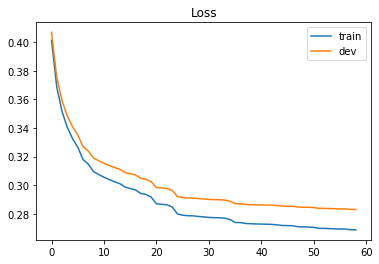

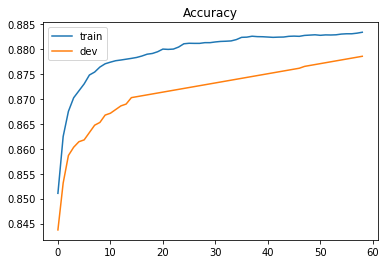

In [18]:
import matplotlib.pyplot as plt


# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('./../fig/loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('./../fig/acc.png')
plt.show()

## Keep training by using lower learning rate

In [81]:
# Some parameters for training    
max_iter = 6000
batch_size = 4000
learning_rate = 0.0000001
early_stopping_iter = 50
y_dev_pred = _f(X_dev, w, b)
Y_dev_pred = np.round(y_dev_pred)
temp_acc = _accuracy(Y_dev_pred, Y_dev)
temp_epoch = 0

# Calcuate the number of parameter updates
step = 1

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
    
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
            
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
        
        y_train_pred = _f(X_train, w, b)
        Y_train_pred = np.round(y_train_pred)
        T_acc = _accuracy(Y_train_pred, Y_train)
        T_loss = _cross_entropy_loss(y_train_pred, Y_train) / train_size
        
        y_dev_pred = _f(X_dev, w, b)
        Y_dev_pred = np.round(y_dev_pred)
        D_acc = _accuracy(Y_dev_pred, Y_dev)
        D_loss = _cross_entropy_loss(y_dev_pred, Y_dev) / dev_size
        
        # progress bar
        if idx == int(np.floor(train_size / batch_size)) - 1:
            _progress_bar(epoch+1, max_iter, 100., T_acc, T_loss, D_acc, D_loss)
        else:
            _progress_bar(epoch+1, max_iter, idx * batch_size * 100 / train_size, T_acc, T_loss, D_acc, D_loss)
    
    train_acc.append(T_acc)
    train_loss.append(T_loss)

    dev_acc.append(D_acc)
    dev_loss.append(D_loss)
        
    # early stopping
    if D_acc > temp_acc:
        temp_acc = np.copy(D_acc)
        temp_epoch = 0
        
        temp_w = np.copy(w)
        temp_b = np.copy(b)
        temp_step = np.copy(step)
    else:
        if temp_epoch < early_stopping_iter:
            temp_epoch += 1
        else:
            print("early stopping at epoch:", epoch - temp_epoch)
            
            train_acc[:-temp_epoch-1]
            train_loss[:-temp_epoch-1]

            dev_acc[:-temp_epoch-1]
            dev_loss[:-temp_epoch-1]
            
            w = temp_w
            b = temp_b
            step = temp_step
            break

 [Epoch 1/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2663 dev_acc: 0.8800 dev_loss: 0.2814 ;

 [Epoch 2/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2663 dev_acc: 0.8800 dev_loss: 0.2814 ;

 [Epoch 3/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2663 dev_acc: 0.8800 dev_loss: 0.2814 ;

 [Epoch 4/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2663 dev_acc: 0.8800 dev_loss: 0.2814 ;

 [Epoch 5/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2663 dev_acc: 0.8800 dev_loss: 0.2814 ;

 [Epoch 6/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2663 dev_acc: 0.8800 dev_loss: 0.2814 ;

 [Epoch 7/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2663 dev_acc: 0.8800 dev_loss: 0.2814 ;

 [Epoch 8/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2663 dev_acc: 0.8800 dev_loss: 0.2814 ;

 [Epoch 9/6000]:[██████████]100.0% training_acc: 0.8845 training_loss: 0.2663 dev_acc: 0

In [82]:
print('[Best model]',
      'training acc:', train_acc[-1],
      '\n',
      'training loss:', train_loss[-1],
      '\n',
      'development acc:', dev_acc[-1],
      '\n',
      'development loss:', dev_loss[-1])

[Best model] training acc: 0.8845177145197625 
 training loss: 0.2662657394026112 
 development acc: 0.8800221157390343 
 development loss: 0.28138237802993626


In [83]:
y_dev_pred = _f(X_dev, w, b)
Y_dev_pred = np.round(y_dev_pred)
D_acc = _accuracy(Y_dev_pred, Y_dev)
D_loss = _cross_entropy_loss(y_dev_pred, Y_dev) / dev_size

In [84]:
D_acc

0.8800221157390343

### Predicting testing labels

Predictions are saved to *output_logistic.csv*.

預測測試集的資料標籤並且存在 *output_logistic.csv* 中。

In [85]:
# Predict testing labels
predictions = _predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Mexican-American 0.9305205167421388
 Do not know 0.6382392196245879
 South Korea 0.593700859873409
id 0.49231588533069526
 Grandchild 18+ ever marr not in subfamily 0.3612821655872186
 44 0.32178651546653336
 Professional specialty 0.26206563728990634
 Protective services -0.26206563728990623
 41 0.2597418780784859
 0 0.23624391989434032
